In [ ]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"


In [ ]:
import gym_envs
import gymnasium as gym
env = gym.make('gym_envs/TicTacToe-v0')

state, info = env.reset()
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
env.render()
state, reward, terminated, truncated, info = env.step(0)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(4)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(3)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(6)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(2)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(1)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
env.render()
state, reward, terminated, truncated, info = env.step(7)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(8)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(5)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
print("Truncated:", truncated)
env.render()


env.reset()
state, reward, terminated, truncated, info = env.step(0)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(3)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(7)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(4)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(2)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(6)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
state, reward, terminated, truncated, info = env.step(1)
print(state)
print("Turn: ", state[2][0][0])
print("Legal moves: ", info['legal_moves'])
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Reward:", reward)



In [ ]:
class NormalizeZeroToOne(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_high = self.env.observation_space.high
        self.observation_low = self.env.observation_space.low

    def observation(self, obs):
        print(obs)
        print((obs - self.observation_low) / (self.observation_high - self.observation_low))
        return (obs - self.observation_low) / (self.observation_high - self.observation_low)

In [ ]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)

    def reward(self, reward):
        return np.clip(reward, self.min_reward, self.max_reward)

In [ ]:
# env = gym.wrappers.AtariPreprocessing(gym.make("ALE/MsPacman-v5", render_mode="rgb_array"), terminal_on_life_loss=True, scale_obs=True) # as seen online with frame stackign though
# env = gym.wrappers.AtariPreprocessing(gym.make("ALE/MsPacman-v5", render_mode="rgb_array"), terminal_on_life_loss=True, scale_obs=True) # as seen online
env = ClipReward(gym.wrappers.AtariPreprocessing(gym.make("MsPacmanNoFrameskip-v4", render_mode="rgb_array"), terminal_on_life_loss=True), -1, 1) # as recommended by the original paper, should already include max pooling
env = gym.wrappers.FrameStack(env, 4)

In [13]:
from rainbow_agent import RainbowAgent
import gymnasium as gym
import numpy as np
import tensorflow as tf
from hyperopt import hp

In [14]:
def create_search_space():
    search_space = {
        "activation": hp.choice(
            "activation",
            [
                "linear",
                "relu",
                # 'relu6',
                "sigmoid",
                "softplus",
                "soft_sign",
                "silu",
                "swish",
                "log_sigmoid",
                "hard_sigmoid",
                # 'hard_silu',
                # 'hard_swish',
                # 'hard_tanh',
                "elu",
                # 'celu',
                "selu",
                "gelu",
                # 'glu'
            ],
        ),
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "lecun_uniform",
                "lecun_normal",
                "orthogonal",
                "variance_baseline",
                "variance_0.1",
                "variance_0.3",
                "variance_0.8",
                "variance_3",
                "variance_5",
                "variance_10",
            ],
        ),
        "optimizer": hp.choice(
            "optimizer", [tf.keras.optimizers.legacy.Adam]
        ),  # NO SGD OR RMSPROP FOR NOW SINCE IT IS FOR RAINBOW DQN
        "learning_rate": hp.choice(
            "learning_rate", [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        ),  #
        "adam_epsilon": hp.choice(
            "adam_epsilon",
            [1, 0.5, 0.3125, 0.03125, 0.003125, 0.0003125, 0.00003125, 0.000003125],
        ),
        "clipnorm": hp.choice("clipnorm", [None]),
        # NORMALIZATION?
        "soft_update": hp.choice(
            "soft_update", [False]
        ),  # seems to always be false, we can try it with tru
        "ema_beta": hp.uniform("ema_beta", 0.95, 0.999),
        "transfer_interval": hp.choice(
            "transfer_interval", [10, 25, 50, 100, 200, 400, 800, 1600, 2000]
        ),
        "replay_interval": hp.choice("replay_interval", [1, 2, 3, 4, 5, 8, 10, 12]),
        "minibatch_size": hp.choice(
            "minibatch_size", [2**i for i in range(0, 8)]
        ),  ###########
        "replay_buffer_size": hp.choice(
            "replay_buffer_size", [2000, 3000, 5000, 7500, 10000, 15000, 20000, 25000, 50000]
        ),  #############
        "min_replay_buffer_size": hp.choice(
            "min_replay_buffer_size", [0, 125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000]
        ),  # 125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000
        "n_step": hp.choice("n_step", [1, 2, 3, 4, 5, 8, 10]),
        "discount_factor": hp.choice(
            "discount_factor", [0.1, 0.5, 0.9, 0.99, 0.995, 0.999]
        ),
        "atom_size": hp.choice("atom_size", [11, 21, 31, 41, 51, 61, 71, 81]),  #
        "conv_layers": hp.choice("conv_layers", [[], [(32, 8, 4), (64, 4, 2), (64, 3, 1)]]),
        "conv_layers_noisy": hp.choice("conv_layers_noisy", [False]),
        "width": hp.choice("width", [32, 64, 128, 256, 512, 1024]),
        "dense_layers": hp.choice("dense_layers", [0, 1, 2, 3, 4]),
        "dense_layers_noisy": hp.choice(
            "dense_layers_noisy", [True]
        ),  # i think this is always true for rainbow
        # REWARD CLIPPING
        "noisy_sigma": hp.choice("noisy_sigma", [0.5]),  #
        "loss_function": hp.choice(
            "loss_function",
            [tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.KLDivergence()],
        ),
        "dueling": hp.choice("dueling", [True]),
        "advantage_hidden_layers": hp.choice(
            "advantage_hidden_layers", [0, 1, 2, 3, 4]
        ),  #
        "value_hidden_layers": hp.choice("value_hidden_layers", [0, 1, 2, 3, 4]),  #
        "training_steps": hp.choice("training_steps", [30000]),
        "per_epsilon": hp.choice(
            "per_epsilon", [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
        ),
        "per_alpha": hp.choice("per_alpha", [0.05 * i for i in range(0, 21)]),
        "per_beta": hp.choice("per_beta", [0.05 * i for i in range(1, 21)]),
        # 'per_beta_increase': hp.uniform('per_beta_increase', 0, 0.015),
        "v_min": hp.choice("v_min", [-500.0]),  # MIN GAME SCORE
        "v_max": hp.choice("v_max", [500.0]),  # MAX GAME SCORE
        # 'search_max_depth': 5,
        # 'search_max_time': 10,
    }
    initial_best_config = [
        {
            "activation": 1,
            "kernel_initializer": 6,
            "optimizer": 0,  # NO SGD OR RMSPROP FOR NOW SINCE IT IS FOR RAINBOW DQN
            "learning_rate": 5,  #
            "adam_epsilon": 5,
            "clipnorm": 0,
            # NORMALIZATION?
            "soft_update": 0,  # seems to always be false, we can try it with tru
            "ema_beta": 0.95,
            "transfer_interval": 3,
            "replay_interval": 3,
            "minibatch_size": 7,
            "replay_buffer_size": 8,  
            "min_replay_buffer_size": 4,
            "n_step": 2,
            "discount_factor": 3,
            "atom_size": 4,  #
            "conv_layers": 0,
            "conv_layers_noisy": 0,
            "width": 4,
            "dense_layers": 2,
            "dense_layers_noisy": 0,  # i think this is always true for rainbow
            # REWARD CLIPPING
            "noisy_sigma": 0,  #
            "loss_function": 0,
            "dueling": 0,
            "advantage_hidden_layers": 0,  #
            "value_hidden_layers": 0,  #
            "training_steps": 0,
            "per_epsilon": 3,
            "per_alpha": 10,
            "per_beta": 7,
            # 'per_beta_increase': hp.uniform('per_beta_increase', 0, 0.015),
            "v_min": 0,  # MIN GAME SCORE
            "v_max": 0,  # MAX GAME SCORE
            # 'search_max_depth': 5,
            # 'search_max_time': 10,
        }
    ]

    return search_space, initial_best_config


In [15]:
from hyperopt import space_eval

search_sapce, initial_best_config = create_search_space()
config = space_eval(search_sapce, initial_best_config[0])
print(config)


{'activation': 'relu', 'adam_epsilon': 0.0003125, 'advantage_hidden_layers': 0, 'atom_size': 51, 'clipnorm': None, 'conv_layers': (), 'conv_layers_noisy': False, 'dense_layers': 2, 'dense_layers_noisy': True, 'discount_factor': 0.99, 'dueling': True, 'ema_beta': 0.95, 'kernel_initializer': 'orthogonal', 'learning_rate': 0.01, 'loss_function': <keras.src.losses.CategoricalCrossentropy object at 0x2e09eaf40>, 'min_replay_buffer_size': 500, 'minibatch_size': 128, 'n_step': 3, 'noisy_sigma': 0.5, 'optimizer': <class 'keras.src.optimizers.legacy.adam.Adam'>, 'per_alpha': 0.5, 'per_beta': 0.4, 'per_epsilon': 0.001, 'replay_buffer_size': 50000, 'replay_interval': 4, 'soft_update': False, 'training_steps': 30000, 'transfer_interval': 100, 'v_max': 500.0, 'v_min': -500.0, 'value_hidden_layers': 0, 'width': 512}


In [16]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

Using adam_epsilon: 0.0003125
Using learning_rate: 0.01
Using clipnorm: None
Using optimizer: <class 'keras.src.optimizers.legacy.adam.Adam'>
Using loss_function: <keras.src.losses.CategoricalCrossentropy object at 0x2e09eaf40>
Using default training_iterations: 1
Using default num_minibatches: 1
Using minibatch_size: 128
Using replay_buffer_size: 50000
Using min_replay_buffer_size: 500
Using training_steps: 30000
Using activation: relu
Using kernel_initializer: orthogonal
Using width: 512
Using noisy_sigma: 0.5
Using conv_layers: ()
Using conv_layers_noisy: False
Using dense_layers: 2
Using dense_layers_noisy: True
Using value_hidden_layers: 0
Using advantage_hidden_layers: 0
Using discount_factor: 0.99
Using soft_update: False
Using transfer_interval: 100
Using ema_beta: 0.95
Using replay_interval: 4
Using per_alpha: 0.5
Using per_beta: 0.4
Using per_epsilon: 0.001
Using n_step: 3
Using atom_size: 51
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/rainbow/videos/RainbowDQN-

/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/rainbow/videos/RainbowDQN-CartPole-v1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


10
./videos/RainbowDQN-CartPole-v1/10
score:  14.0
score:  19.0
score:  18.0
score:  16.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/10/RainbowDQN-CartPole-v1-episode-4.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/10/RainbowDQN-CartPole-v1-episode-4.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/10/RainbowDQN-CartPole-v1-episode-4.mp4
score:  14.0
20
./videos/RainbowDQN-CartPole-v1/20
score:  21.0
score:  19.0
score:  18.0
score:  18.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/20/RainbowDQN-CartPole-v1-episode-9.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/20/RainbowDQN-CartPole-v1-episode-9.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/20/RainbowDQN-CartPole-v1-episode-9.mp4
score:  21.0


/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


30
./videos/RainbowDQN-CartPole-v1/30
score:  12.0
score:  14.0
score:  14.0
score:  12.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/30/RainbowDQN-CartPole-v1-episode-14.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/30/RainbowDQN-CartPole-v1-episode-14.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/30/RainbowDQN-CartPole-v1-episode-14.mp4
score:  16.0
40
./videos/RainbowDQN-CartPole-v1/40
score:  25.0
score:  28.0
score:  28.0
score:  23.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/40/RainbowDQN-CartPole-v1-episode-19.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/40/RainbowDQN-CartPole-v1-episode-19.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/40/RainbowDQN-CartPole-v1-episode-19.mp4
score:  87.0


50
./videos/RainbowDQN-CartPole-v1/50
score:  20.0
score:  17.0
score:  27.0
score:  17.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/50/RainbowDQN-CartPole-v1-episode-24.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/50/RainbowDQN-CartPole-v1-episode-24.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/50/RainbowDQN-CartPole-v1-episode-24.mp4
score:  20.0
60
./videos/RainbowDQN-CartPole-v1/60
score:  28.0
score:  19.0
score:  16.0
score:  12.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/60/RainbowDQN-CartPole-v1-episode-29.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/60/RainbowDQN-CartPole-v1-episode-29.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/60/RainbowDQN-CartPole-v1-episode-29.mp4
score:  16.0


70
./videos/RainbowDQN-CartPole-v1/70
score:  54.0
score:  23.0
score:  42.0
score:  57.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/70/RainbowDQN-CartPole-v1-episode-34.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/70/RainbowDQN-CartPole-v1-episode-34.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/70/RainbowDQN-CartPole-v1-episode-34.mp4
score:  45.0


80
./videos/RainbowDQN-CartPole-v1/80
score:  15.0
score:  23.0
score:  48.0
score:  18.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/80/RainbowDQN-CartPole-v1-episode-39.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/80/RainbowDQN-CartPole-v1-episode-39.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/80/RainbowDQN-CartPole-v1-episode-39.mp4
score:  20.0


90
./videos/RainbowDQN-CartPole-v1/90
score:  20.0
score:  16.0
score:  61.0
score:  15.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/90/RainbowDQN-CartPole-v1-episode-44.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/90/RainbowDQN-CartPole-v1-episode-44.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/90/RainbowDQN-CartPole-v1-episode-44.mp4
score:  23.0


100
./videos/RainbowDQN-CartPole-v1/100
score:  55.0
score:  64.0
score:  15.0
score:  19.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/100/RainbowDQN-CartPole-v1-episode-49.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/100/RainbowDQN-CartPole-v1-episode-49.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/100/RainbowDQN-CartPole-v1-episode-49.mp4
score:  18.0


110
./videos/RainbowDQN-CartPole-v1/110
score:  75.0
score:  82.0
score:  76.0
score:  78.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/110/RainbowDQN-CartPole-v1-episode-54.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/110/RainbowDQN-CartPole-v1-episode-54.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/110/RainbowDQN-CartPole-v1-episode-54.mp4
score:  78.0
120
./videos/RainbowDQN-CartPole-v1/120
score:  80.0
score:  69.0
score:  72.0
score:  69.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/120/RainbowDQN-CartPole-v1-episode-59.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/120/RainbowDQN-CartPole-v1-episode-59.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/120/RainbowDQN-CartPole-v1-episode-59.mp4
score:  72.0


130
./videos/RainbowDQN-CartPole-v1/130
score:  77.0
score:  84.0
score:  78.0
score:  70.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/130/RainbowDQN-CartPole-v1-episode-64.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/130/RainbowDQN-CartPole-v1-episode-64.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/130/RainbowDQN-CartPole-v1-episode-64.mp4
score:  71.0


140
./videos/RainbowDQN-CartPole-v1/140
score:  79.0
score:  82.0
score:  81.0
score:  80.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/140/RainbowDQN-CartPole-v1-episode-69.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/140/RainbowDQN-CartPole-v1-episode-69.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/140/RainbowDQN-CartPole-v1-episode-69.mp4
score:  80.0
150
./videos/RainbowDQN-CartPole-v1/150
score:  93.0
score:  97.0
score:  104.0
score:  98.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/150/RainbowDQN-CartPole-v1-episode-74.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/150/RainbowDQN-CartPole-v1-episode-74.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/150/RainbowDQN-CartPole-v1-episode-74.mp4
score:  98.0
160
./videos/RainbowDQN-CartPole-v1/160
score:  58.0
score:  67.0
score:  62.0
score:  58.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/160/RainbowDQN-CartPole-v1-episode-79.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/160/RainbowDQN-CartPole-v1-episode-79.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/160/RainbowDQN-CartPole-v1-episode-79.mp4
score:  60.0


170
./videos/RainbowDQN-CartPole-v1/170
score:  73.0
score:  75.0
score:  67.0
score:  71.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/170/RainbowDQN-CartPole-v1-episode-84.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/170/RainbowDQN-CartPole-v1-episode-84.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/170/RainbowDQN-CartPole-v1-episode-84.mp4
score:  69.0


180
./videos/RainbowDQN-CartPole-v1/180
score:  88.0
score:  91.0
score:  92.0
score:  92.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/180/RainbowDQN-CartPole-v1-episode-89.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/180/RainbowDQN-CartPole-v1-episode-89.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/180/RainbowDQN-CartPole-v1-episode-89.mp4
score:  88.0
190
./videos/RainbowDQN-CartPole-v1/190
score:  62.0
score:  64.0
score:  64.0
score:  77.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/190/RainbowDQN-CartPole-v1-episode-94.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/190/RainbowDQN-CartPole-v1-episode-94.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/190/RainbowDQN-CartPole-v1-episode-94.mp4
score:  75.0


200
./videos/RainbowDQN-CartPole-v1/200
score:  74.0
score:  78.0
score:  77.0
score:  72.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/200/RainbowDQN-CartPole-v1-episode-99.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/200/RainbowDQN-CartPole-v1-episode-99.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/200/RainbowDQN-CartPole-v1-episode-99.mp4
score:  83.0


210
./videos/RainbowDQN-CartPole-v1/210
score:  79.0
score:  82.0
score:  78.0
score:  84.0
Moviepy - Building video ./videos/RainbowDQN-CartPole-v1/210/RainbowDQN-CartPole-v1-episode-104.mp4.
Moviepy - Writing video ./videos/RainbowDQN-CartPole-v1/210/RainbowDQN-CartPole-v1-episode-104.mp4



Moviepy - Done !
Moviepy - video ready ./videos/RainbowDQN-CartPole-v1/210/RainbowDQN-CartPole-v1-episode-104.mp4
score:  88.0


KeyboardInterrupt: 

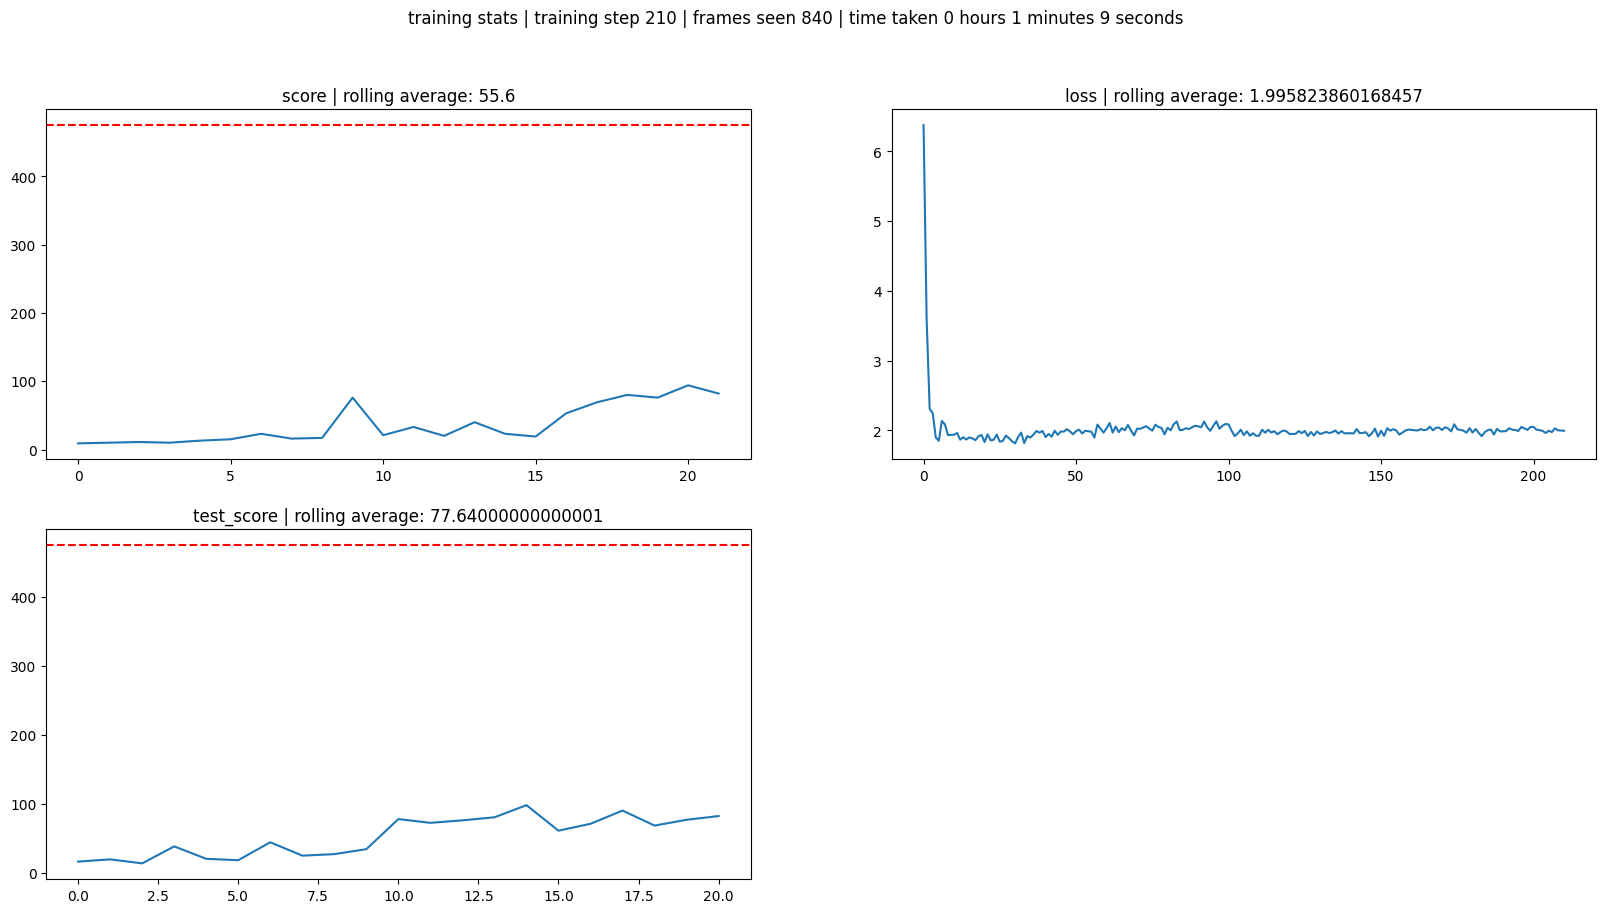

In [17]:
from agent_configs import RainbowConfig
from game_configs import CartPoleConfig
config = RainbowConfig(config, CartPoleConfig())
# train
agent = RainbowAgent(env, config, "RainbowDQN-{}".format(env.unwrapped.spec.id))
agent.train()